In [1]:
data_dir = "data/geolife/Data/"
sample_s = 5
sample_q = 5
y_timestep = 5 # must be less than length
length = y_timestep*2 #10
train_size = 0.2
validation_size = 0.1
batch_size = 1
gap=10

is_train = False
best_model_path = 'best_model.pth'

from args            import argument_parser
import ast
import datetime

import torch
from torch_time_het import TimeHetNet

In [2]:
# TensorBoard 설정

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./data/geolife/runs/timehet_test1')

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch_geolife_dateset import GeoLifeDataSet
from data.geolife.convert_minmax_location import LocationPreprocessor
import random

locationPreprocessor = LocationPreprocessor('data/geolife/')
user_df = locationPreprocessor.get_valid_user_list()
user_list = []
for user in user_df['valid_user_list']:
    user_list += [locationPreprocessor.getUserId(user)]

random.shuffle(user_list)

train_len       = (int)(len(user_list) * train_size)
validation_len  = (int)(len(user_list) * validation_size)

train_list      = user_list[:train_len]
validation_list = user_list[train_len:(train_len + validation_len)]
test_list       = user_list[(train_len + validation_len):(train_len + validation_len + 10)]
# test_list       = user_list[(train_len + validation_len):]
print(f"train_list:      {train_list}")
print(f"validation_list: {validation_list}")
print(f"test_list:       {test_list}")

training_data   = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep, gap)
validation_data = GeoLifeDataSet(data_dir, validation_list, sample_s, sample_q, length, y_timestep, gap)
test_data       = GeoLifeDataSet(data_dir, test_list, sample_s, sample_q, length, y_timestep, gap)

train_dataloader      = DataLoader(training_data, batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=False)
test_dataloader       = DataLoader(test_data, batch_size, shuffle=False)

best_model = TimeHetNet(dims_inf = ast.literal_eval("[32,32,32]"),
                        dims_pred = ast.literal_eval("[32,32,32]"), 
                        activation="relu", 
                        time=100,
                        batchnorm=False, 
                        block = str("gru,conv,conv,gru").split(","),
                        output_shape=[y_timestep, 2],
                        length=length)
best_model.load_state_dict(torch.load(best_model_path))

2024-01-18 17:16:55.336748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 17:16:55.336817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 17:16:55.338883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 17:16:55.352789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 17:16:56.249868: W tensorflow/compiler/tf2

train_list:      ['070', '174', '119', '161', '074', '151', '048', '045', '095', '152', '049', '050', '113', '044', '001', '181', '008', '007', '077', '081', '055', '061', '147', '038', '154']
validation_list: ['141', '026', '104', '047', '133', '148', '112', '031', '085', '039', '165', '075']
test_list:       ['014', '101', '150', '121', '006', '138', '058', '018', '032', '180']


<All keys matched successfully>

In [3]:
class_probs = []
class_label = []
que_x_list = []

with torch.no_grad():
    for data in test_dataloader:
        test_X, test_y = data
        if len(test_X) < 2:
            continue
        que_x, _, _ = test_X
        output = best_model(test_X)
        # output = torch.reshape(output, [output.shape[0], -1, output.shape[-1]])
        # test_y = torch.reshape(test_y, [test_y.shape[0], -1, test_y.shape[-1]])
        class_probs.append(output)
        class_label.append(test_y)
        # que_x: torch.Size([1, 5, 1000, 2])
        que_x_list.append(que_x[:, :, -y_timestep:, :])
        
print(len(class_probs))
print(len(class_label))
print(len(que_x_list))

test_probs = torch.cat(class_probs)
test_label = torch.cat(class_label)
test_que_x = torch.cat(que_x_list)

print(test_probs.shape)
print(test_label.shape)
print(test_que_x.shape)

10
10
10
torch.Size([10, 5, 5, 2])
torch.Size([10, 5, 5, 2])
torch.Size([10, 5, 5, 1])


In [4]:
# test_label[0][0][:, 1]

from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler.fit(test_que_x[0][1])
import pandas as pd

df = pd.DataFrame(data=test_que_x[0][1], columns=['Time'])

df_norm = MinMaxScaler().fit_transform(df)
df_norm
test_que_x[0][2]

tensor([[39918.3555],
        [39918.3555],
        [39918.3555],
        [39918.3555],
        [39918.3555]])

[[0.      ]
 [0.046875]
 [0.125   ]
 [0.40625 ]
 [1.      ]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[0.       ]
 [0.       ]
 [0.0078125]
 [0.015625 ]
 [1.       ]]
[[0. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]]
[[0.  ]
 [0.  ]
 [0.25]
 [0.75]
 [1.  ]]
[[0.  ]
 [0.25]
 [0.75]
 [0.75]
 [1.  ]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[0.  ]
 [0.5 ]
 [0.75]
 [0.75]
 [1.  ]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[0.   ]
 [0.125]
 [0.375]
 [0.75 ]
 [1.   ]]


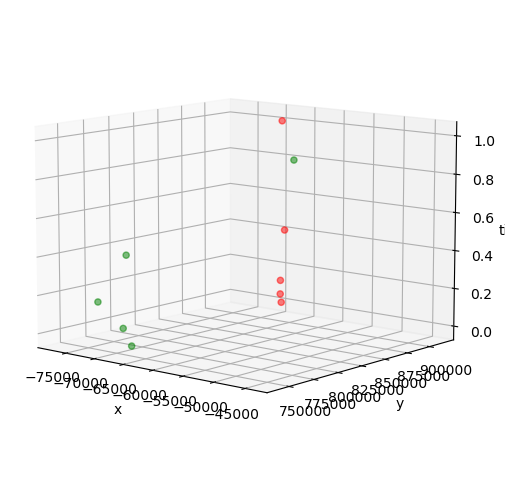

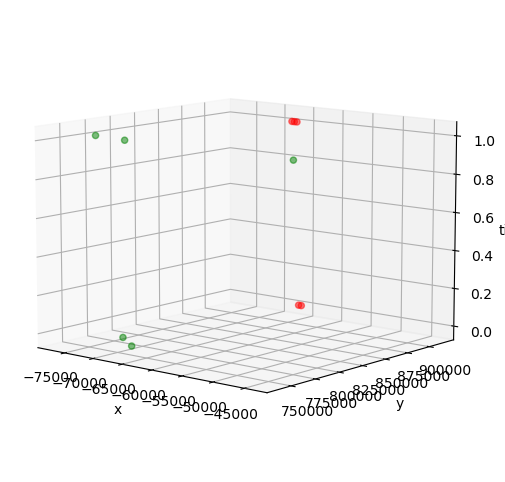

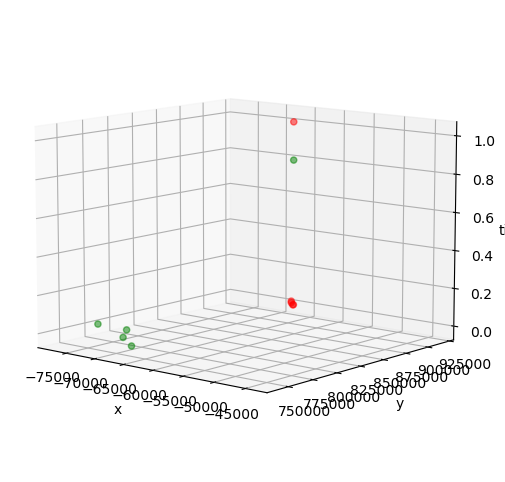

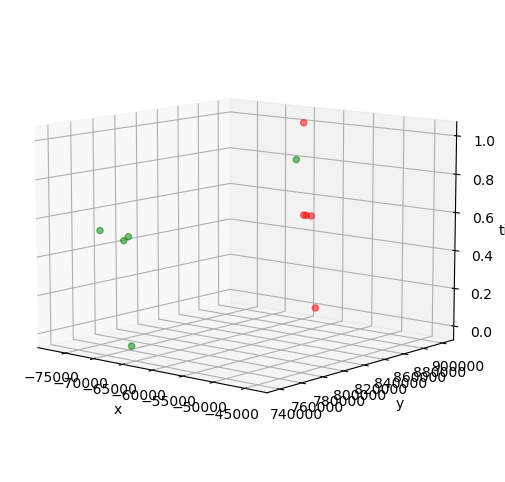

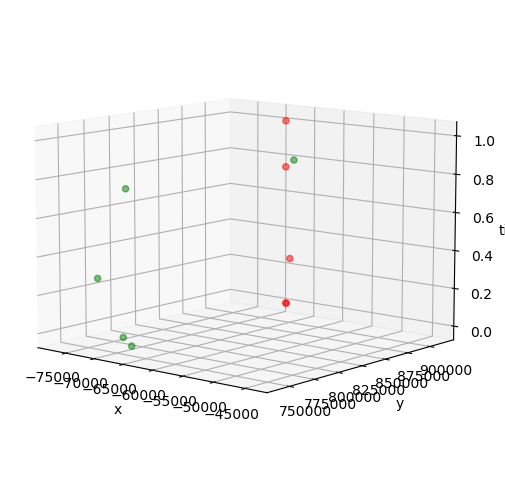

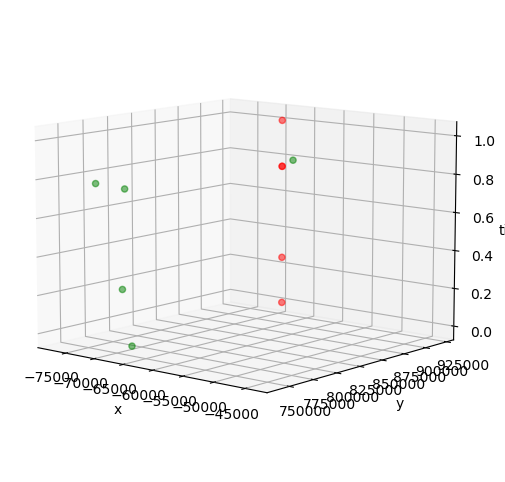

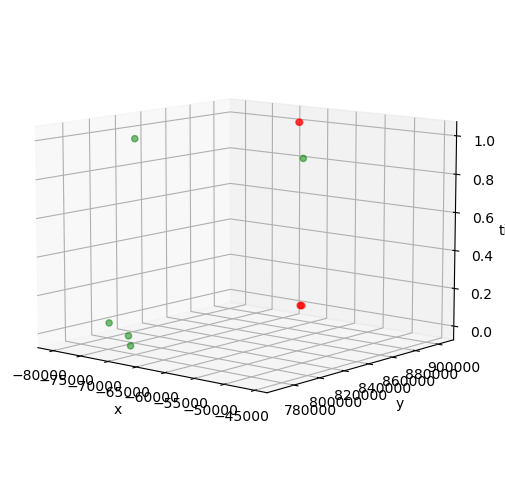

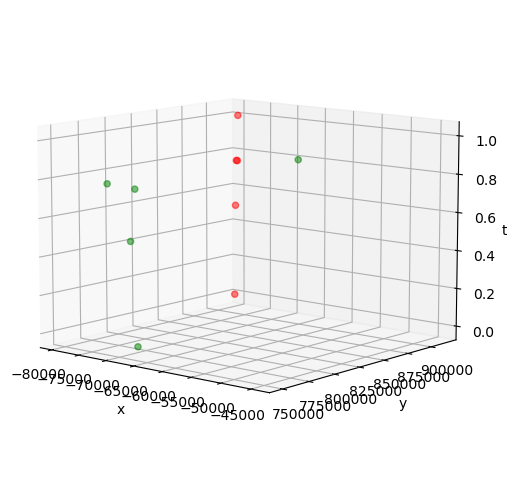

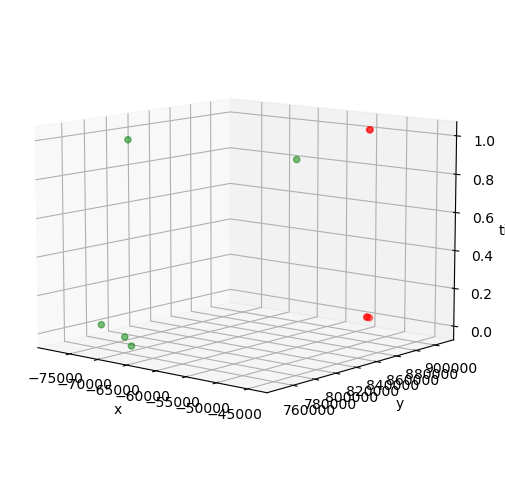

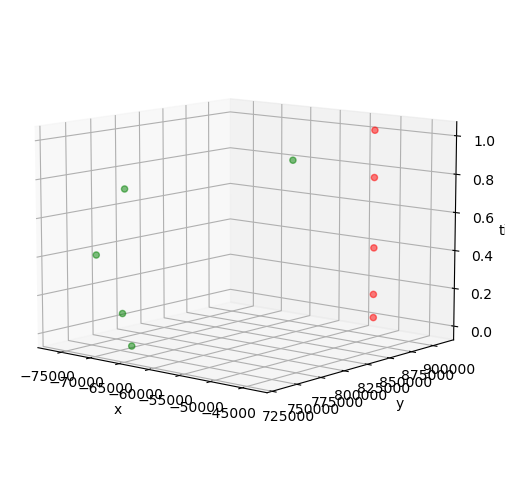

In [5]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x, y, z, color = 'r', alpha = 0.5)
# ax.scatter(x, z, y, color = 'g', alpha = 0.5) # y와 z축 swap

for idx in range(test_label.shape[0]):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10, azim=-50)
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)
    ax.scatter(test_label[idx][0][:, 0], test_label[idx][0][:, 1], df_norm,
               color='r', alpha=0.5)
    ax.scatter(test_probs[idx][0][:, 0], test_probs[idx][0][:, 1], df_norm, 
               color='g', alpha=0.5)
    print(df_norm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('time')

In [14]:
# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F

from torch import optim

import pandas as pd

class My_Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, name=None):
        super(My_Linear, self).__init__()
        self.Linear = nn.Linear(in_features, out_features, bias, device)
        self.name = name
    
    def forward(self, x):
        # print(f"My_Linear - X.shape: {x.shape}, name: {self.name}")
        x = self.Linear(x)
        return x

In [3]:
df = pd.read_csv('data/geolife/Data/000/csv/000.csv')
df.head(1)
df_test = df.iloc[:, :-2].copy()
df_test.head(1)

,latitude,longitude,what,altitude,days
0,39.984702,116.318417,0,492,39744.120185


In [4]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [21]:
X = ['latitude', 'longitude', 'altitude', 'days']
df_x = df_test[X].head(10).copy()
df_x = df_to_tensor(df_x)
print(df_x)
df_x = df_x.unsqueeze(axis=-1)
print(df_x)
df_x = df_x.sum(axis=2)
print(df_x)

tensor([[   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3185,   492.0000, 39744.1211],
        [   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3184,   492.0000, 39744.1211],
        [   39.9847,   116.3183,   492.0000, 39744.1211],
        [   39.9846,   116.3180,   493.0000, 39744.1211],
        [   39.9846,   116.3178,   493.0000, 39744.1211],
        [   39.9846,   116.3175,   496.0000, 39744.1211],
        [   39.9845,   116.3173,   500.0000, 39744.1211],
        [   39.9846,   116.3171,   505.0000, 39744.1211]])
tensor([[[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3185],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3184],
         [  492.0000],
         [39744.1211]],

        [[   39.9847],
         [  116.3183

TypeError: expected np.ndarray (got builtin_function_or_method)

In [30]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_test, train_size=0.7, random_state=123)

X = ['latitude', 'longitude', 'altitude', 'days']
y = ['latitude', 'longitude']

row = 10
train_set = train_set.iloc[:row, :].copy()

train_X = df_to_tensor(train_set[X])
train_y = df_to_tensor(train_set[y])

model = My_Linear(4, 2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
out_list = []
loss_train = 0.0
epochs = 10
for epoch in range(epochs):
    for input in train_X:
        outputs = model(input)
        print(outputs)
        loss = loss_fn(outputs, train_y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    print(f"epoch:{epoch}, loss:{loss_train}")

tensor([ 14446.9902, -13492.7773], grad_fn=<AddBackward0>)
tensor([10405.8428, -9481.2021], grad_fn=<AddBackward0>)
tensor([ 6450.4893, -5513.5981], grad_fn=<AddBackward0>)
tensor([ 2502.3975, -1559.0204], grad_fn=<AddBackward0>)
tensor([-1504.5669,  2443.5837], grad_fn=<AddBackward0>)
tensor([-5533.4468,  6466.4849], grad_fn=<AddBackward0>)
tensor([-9534.4453, 10453.9717], grad_fn=<AddBackward0>)
tensor([-13421.3389,  14243.4980], grad_fn=<AddBackward0>)
tensor([-17012.7188,  17553.1680], grad_fn=<AddBackward0>)
tensor([-19572.9922,  19616.6016], grad_fn=<AddBackward0>)
epoch:0, loss:1346087930.0
tensor([-20963.5742,  20274.4062], grad_fn=<AddBackward0>)
tensor([-20957.9863,  19576.0664], grad_fn=<AddBackward0>)
tensor([-19623.0820,  17774.0215], grad_fn=<AddBackward0>)
tensor([-17550.9297,  15358.5293], grad_fn=<AddBackward0>)
tensor([-14911.8809,  12458.4883], grad_fn=<AddBackward0>)
tensor([-11804.6426,   9166.7256], grad_fn=<AddBackward0>)
tensor([-8373.7852,  5608.7310], grad_fn=

/home/shkoma/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [29]:
train_y

tensor([[ 31.1155, 121.0488],
        [ 40.0045, 116.3137],
        [ 39.9892, 116.2729],
        [ 40.0039, 116.3243],
        [ 40.1208, 116.2123],
        [ 39.9370, 116.3205],
        [ 39.8730, 116.4328],
        [ 39.9940, 116.3268],
        [ 39.9919, 116.3317],
        [ 39.9084, 116.3674]])